In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm
import pickle
import umap
import scipy.sparse as sparse
from scipy.io import mmwrite
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scanpy as sc
import anndata as ad

In [90]:
def load_and_reformat(path_emb, path_labels):
    """Load emb and counts df and reformatting to make them suitable for merge"""
    # Load and reformat embeddings from pickle file
    emb_input = pd.read_pickle(path_emb)
        
    reformatted_emb = {}
    for k, v in emb_input.items():
        new_k = k.replace('-', '_')
        v = v
        reformatted_emb[new_k] = v

    # Load and reformat labels df
    labels = pd.read_csv(path_labels)
    
    reformatted_labels_dict = {}
    counts = labels['Non_redundant']
    names = labels['ID']
    taxa = labels['taxa_short']
    for i in range(len(labels)):
        number = counts[i]
        ID = names[i]
        species = taxa[i]
        not_dash = ID.replace('-', '_')
        clean = not_dash.replace('.', '_')
        reformatted_labels_dict[clean] = number, species

    a = pd.DataFrame.from_dict(reformatted_labels_dict, orient='index')
    reformatted_labels = a.reset_index()
    reformatted_labels.columns = ['ID','Non_redundant','taxa']
    
    # Combine embeddings and ORF2 counts
    matrix_inverted = pd.DataFrame(reformatted_emb)
    matrix = matrix_inverted.transpose()
    
    return reformatted_emb, reformatted_labels, matrix


def match_ID(matrix, reformatted_counts):
    """Matching matrix (embs) and IDs from counts file to use embs observations with counts associated (all)"""
   #matched_IDs = matrix.loc[:, matrix.index.isin(reformatted_counts["ID"].values)]
    matched_emb = matrix.loc[matrix.index.isin(reformatted_labels['ID'].values)]
    matched_labels = reformatted_labels.loc[reformatted_labels['ID'].isin(matrix.index)] 
    return matched_emb, matched_labels

def AnnData_Object(matched_emb):
    """ anndata is a Python package for handling annotated data matrices in memory and on disk, 
        positioned between pandas and xarray"""
    #adata = ad.AnnData(X=matched_IDs.index, obs=pd.DataFrame(index=matched_IDs.columns))
    adata = ad.AnnData(X = matched_emb.values, obs = matched_emb.index.to_list(),var = matched_emb.columns.tolist())
    return adata

def add_labels(adata, matched_labels):
    """Including counts information in emb matrix"""
    ID_embeddings = pd.DataFrame(matched_emb.index)
    ID_embeddings.columns = ["ID"]
    embeddings_labelled = pd.merge(ID_embeddings, matched_labels)
    embeddings_labelled.columns = ['ID', 'Non_redundant', 'taxa']
    #assert all(ID_embeddings.index == ID_embeddings_with_counts["ID"])
    #adata.obs["ORF_all_counts"] = ID_embeddings_with_counts["All"].values
    adata.obs["Non_redundant"] = pd.Categorical(embeddings_labelled["Non_redundant"].values)
    adata.obs["taxa"] = pd.Categorical(embeddings_labelled["taxa"].values)

def dimensionality_reduction(adata, method):
    """Define a function to run dimensionality reduction and visualize"""
    
    # Set up color gradient for labels (labels are stored in a column called "Non_redundant")
    counts_colors = np.linspace(0, 1, len(np.unique(adata.obs["Non_redundant"])))
    counts_cmap = plt.cm.get_cmap("inferno")
    counts_color_dict = dict(zip(np.unique(adata.obs["Non_redundant"]), counts_cmap(counts_colors))) 
    taxa_colors = np.linspace(0, 1, len(np.unique(adata.obs["taxa"])))
    taxa_cmap = plt.cm.get_cmap("viridis")
    taxa_color_dict = dict(zip(np.unique(adata.obs["taxa"]), taxa_cmap(taxa_colors)))
    
    # Scale data (do it only once)
    sc.pp.scale(adata)
    
    if method == "pca":
        # Run PCA
        sc.tl.pca(adata, svd_solver='arpack')
        # Define graph format and color code 
        fig, ax = plt.subplots(figsize=(6, 6))  
        sm = matplotlib.cm.ScalarMappable(norm=plt.Normalize(vmin=min(adata.obs["Non_redundant"]), vmax=max(adata.obs["Non_redundant"])), cmap=counts_cmap)
        sm.set_array([])
        # Generate PCA
        sc.pl.pca(adata, annotate_var_explained=True, color="Non_redundant", size=75, 
                  ax=ax, show=False, palette=counts_color_dict, legend_loc=None)   # palette=counts_color_dict to color dots // save = True
        cbar = plt.colorbar(sm, fraction=0.046, pad=0.04)    # modify color bar size and position
        cbar.ax.set_ylabel("Non_redundant_counts", rotation=270, labelpad=15)  # set label legend
        plt.show()
        
    elif method == "umap":
        # Run PCA first to select PCs for UMAP (RUN THIS BEFORE UMAP!!)
            #sc.tl.pca(adata, n_comps=21)
            #sc.pl.pca_variance_ratio(adata, log=True)
        # Define graph format and color code 
        fig, ax = plt.subplots(figsize=(6, 6))  
        sm = matplotlib.cm.ScalarMappable(norm=plt.Normalize(vmin=min(adata.obs["Non_redundant"]), vmax=max(adata.obs["Non_redundant"])), cmap=counts_cmap)
        sm.set_array([])
        # Generates UMAP
        sc.pp.neighbors(adata, n_neighbors=20, n_pcs=7)
        sc.tl.umap(adata)
        # Visualize UMAP results
        sc.pl.umap(adata, color='Non_redundant', size=75, 
                    ax=ax, show=False, legend_loc=None, palette=counts_color_dict) # legend_loc=None: Do not show all dots in the legend
        cbar = plt.colorbar(sm, fraction=0.046, pad=0.04)    # modify color bar size and position
        cbar.ax.set_ylabel("Non_redundant_counts", rotation=270, labelpad=15)  # set label legend
        plt.show()
        #palette=counts_color_dict
    elif method == "tsne":
        # Apply t-SNE to adata
        sc.tl.tsne(adata)
        # Define color code 
        sm = matplotlib.cm.ScalarMappable(norm=plt.Normalize(vmin=min(adata.obs["Non_redundant"]), vmax=max(adata.obs["Non_redundant"])), cmap=counts_cmap)
        sm.set_array([])
        #cbar = plt.colorbar(sm, fraction=0.046, pad=0.04)    # modify color bar size and position
        #cbar.ax.set_ylabel("Non_redundant_counts", rotation=270, labelpad=15)  # set label legend
        # plot t-SNE results
        sc.pl.tsne(adata, color="Non_redundant", size=75, 
                    show=False, palette=counts_color_dict, legend_loc=None) 
    else:
        print("Invalid method selected. Please choose from 'pca', 'umap', or 'tsne'.")

In [103]:
def test_reduction(adata, method):
    """Define a function to run dimensionality reduction and visualize"""
    
    # Set up color gradient for labels (labels are stored in a column called "Non_redundant")
    label_colors = np.linspace(0, 1, len(np.unique(adata.obs["Non_redundant"])))
    label_cmap = plt.cm.get_cmap("inferno")
    label_color_dict = dict(zip(np.unique(adata.obs["Non_redundant"]), label_cmap(label_colors)))
    taxa_colors = np.linspace(0, 1, len(pd.unique(adata.obs["taxa"])))
    taxa_color_dict = dict(zip(pd.unique(adata.obs["taxa"]), label_cmap(taxa_colors)))
    
    # Scale data (do it only once)
    sc.pp.scale(adata)
    
    if method == "pca":
        # Run PCA
        sc.tl.pca(adata, svd_solver='arpack')
        # Define graph format and color code 
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  
        sm = matplotlib.cm.ScalarMappable(norm=plt.Normalize(vmin=min(adata.obs["Non_redundant"]), vmax=max(adata.obs["Non_redundant"])), cmap=label_cmap)
        sm.set_array([])
        
        # Generate PCA for counts
        sc.pl.pca(adata, annotate_var_explained=True, color="Non_redundant", size=75, 
                  ax=ax1, show=False, palette=label_color_dict, legend_loc=None)   # palette=label_color_dict to color dots // save = True
        cbar = plt.colorbar(sm, ax=ax1, fraction=0.046, pad=0.04)    # modify color bar size and position
        cbar.ax.set_ylabel("Non_redundant_counts", rotation=270, labelpad=15)  # set label legend
        # Generate PCA for taxa
        sc.pl.pca(adata, annotate_var_explained=True, color="taxa", size=75, 
                  ax=ax2, show=False, palette=taxa_color_dict)   # palette=taxa_color_dict to color dots // save = True
        ax2.set_title('Taxonomic label')
        plt.show()
        
    elif method == "umap":
        # Run PCA first to select PCs for UMAP (RUN THIS BEFORE UMAP!!)
            #sc.tl.pca(adata, n_comps=21)
            #sc.pl.pca_variance_ratio(adata, log=True)
        # Define graph format and color code 
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  
        sm1 = matplotlib.cm.ScalarMappable(norm=plt.Normalize(vmin=min(adata.obs["Non_redundant"]), vmax=max(adata.obs["Non_redundant"])), cmap=label)


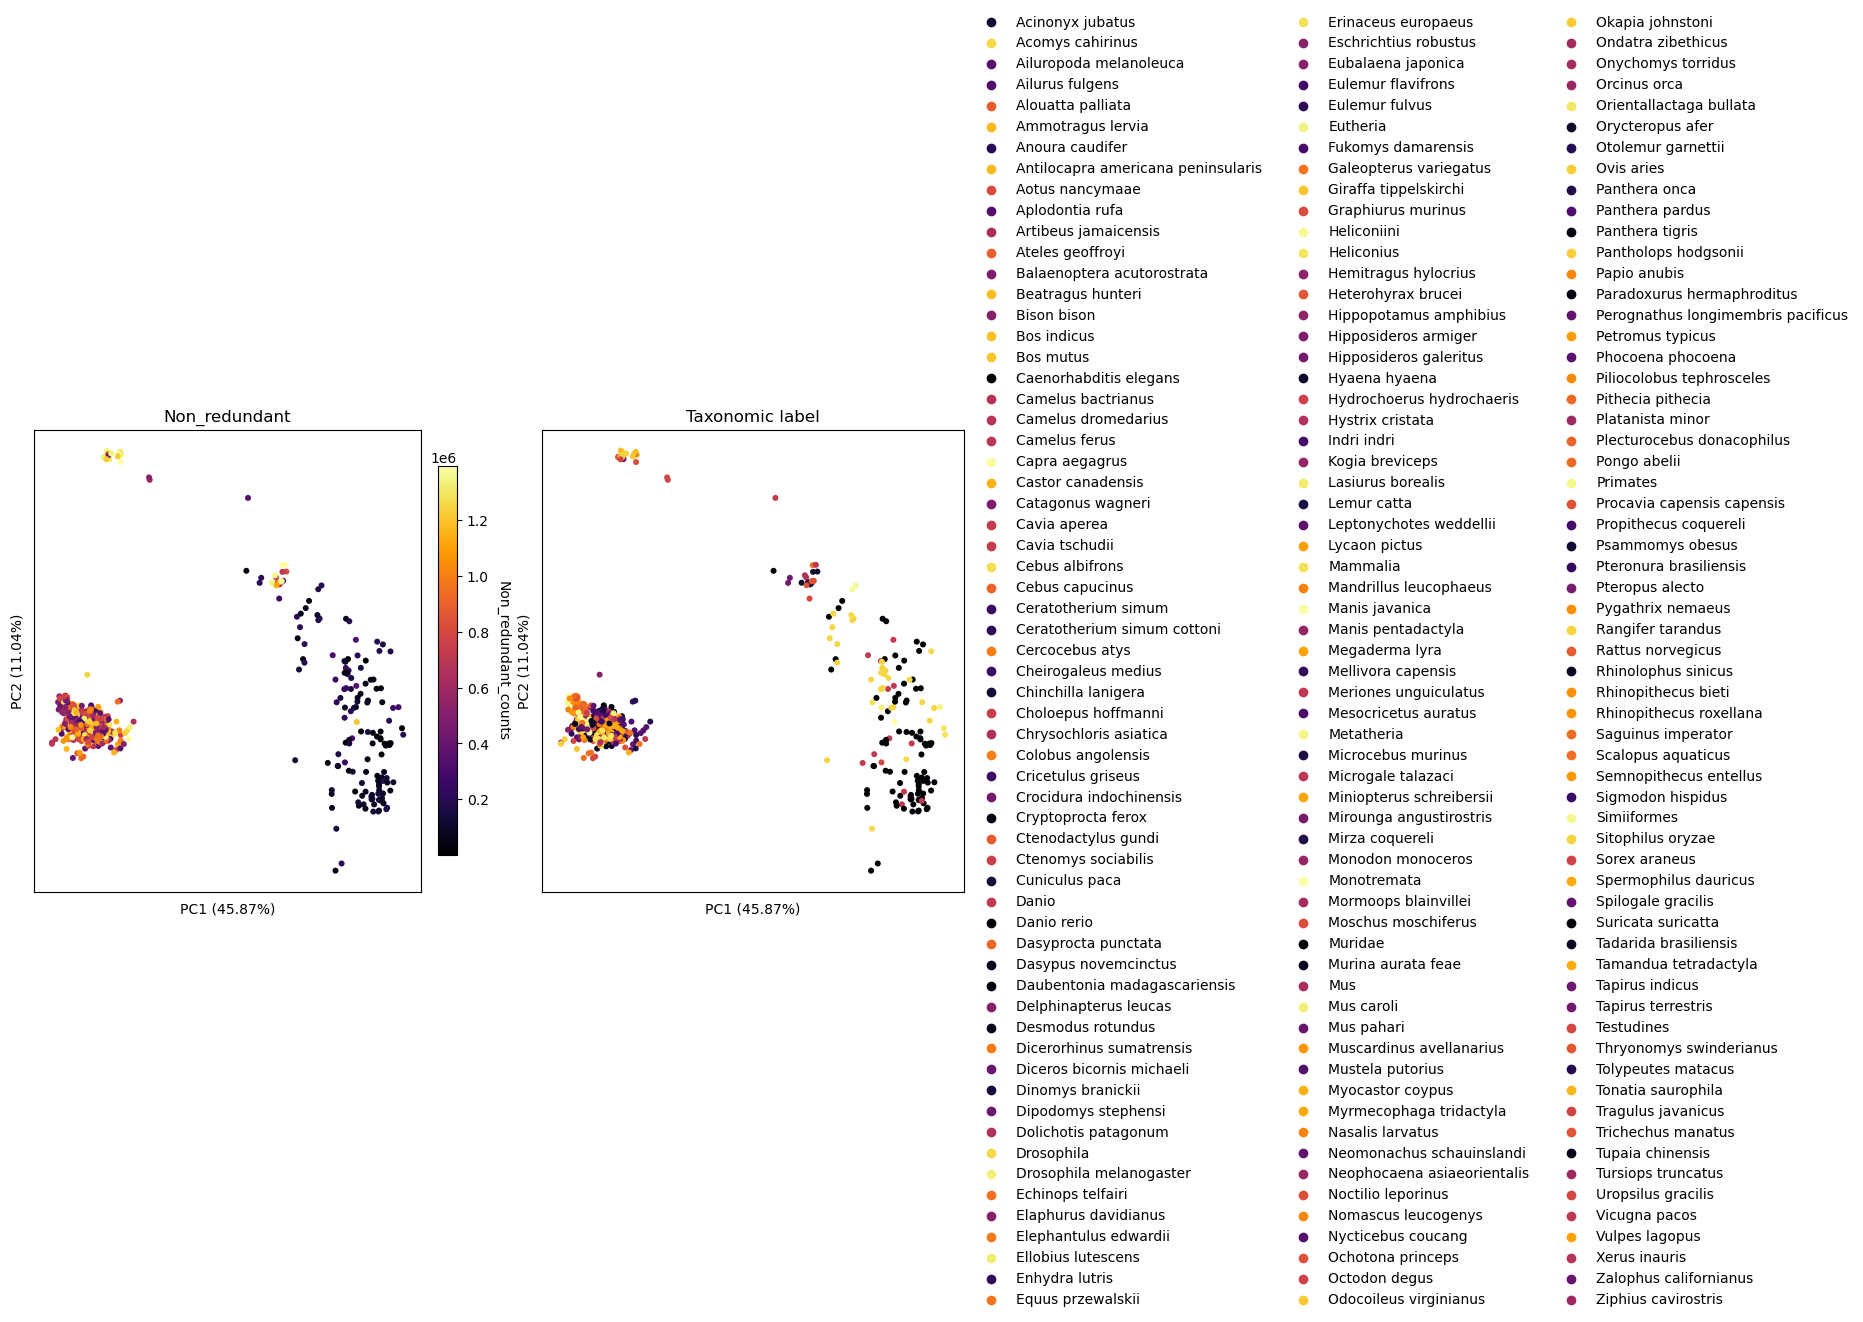

In [104]:
test_reduction(adata, method='pca')

In [106]:
lista = []
for i in matched_labels['taxa']:
    lista.append(i)
len(lista)

720

In [109]:
ola = list(dict.fromkeys(lista))

In [112]:
taxonomy = {
    "Metatheria": [],
    "Primates": [],
    "Eutheria": [],
    "Simiiformes": [],
    "Monotremata": [],
    "Mammalia": [],
    "Testudines": [],
    "Chrysochloris asiatica": [],
    "Heliconiini": [],
    "Heliconius": []
}

for element in ola:
    if "Metatheria" in element:
        taxonomy["Metatheria"].append(element)
    elif "Primates" in element:
        taxonomy["Primates"].append(element)
    elif "Eutheria" in element:
        taxonomy["Eutheria"].append(element)
    elif "Simiiformes" in element:
        taxonomy["Simiiformes"].append(element)
    elif "Monotremata" in element:
        taxonomy["Monotremata"].append(element)
    elif "Mammalia" in element:
        taxonomy["Mammalia"].append(element)
    elif "Testudines" in element:
        taxonomy["Testudines"].append(element)
    elif "Chrysochloris asiatica" in element:
        taxonomy["Chrysochloris asiatica"].append(element)
    elif "Heliconiini" in element:
        taxonomy["Heliconiini"].append(element)
    elif "Heliconius" in element:
        taxonomy["Heliconius"].append(element)

# Print the resulting taxonomy
for category, elements in taxonomy.items():
    print(category + ":")
    print(elements)


Metatheria:
['Metatheria']
Primates:
['Primates']
Eutheria:
['Eutheria']
Simiiformes:
['Simiiformes']
Monotremata:
['Monotremata']
Mammalia:
['Mammalia']
Testudines:
['Testudines']
Chrysochloris asiatica:
['Chrysochloris asiatica']
Heliconiini:
['Heliconiini']
Heliconius:
['Heliconius']


In [59]:
# -- Read pickle file containing embeddings and reformat to remove dash that block merge
path_emb = '/Users/leandro/Desktop/ai_data/embeddings_v2.pickle'
path_labels = '/Users/leandro/Desktop/ai_data/labels.csv'

reformat = load_and_reformat(path_emb, path_labels)

In [60]:
reformatted_emb = reformat[0]
reformatted_labels = reformat[1]
matrix = reformat[2]

In [61]:
# -- Matching datasets
matched_emb = match_ID(matrix, reformatted_labels)[0]
#matches_emb
matched_labels = match_ID(matrix, reformatted_labels)[1]
#matched_labels

In [34]:
print(len(matrix.index), len(matched_emb.index), len(matched_labels.index))  # Test number of matchs between datasets

721 720 720


In [45]:
# -- Create AnnData and including count information
adata = AnnData_Object(matched_emb)

In [91]:
add_labels(adata, matched_labels)

In [92]:
adata.obs_keys

<bound method AnnData.obs_keys of AnnData object with n_obs × n_vars = 720 × 1024
    obs: 0, 'Non_redundant', 'taxa'
    var: 0>

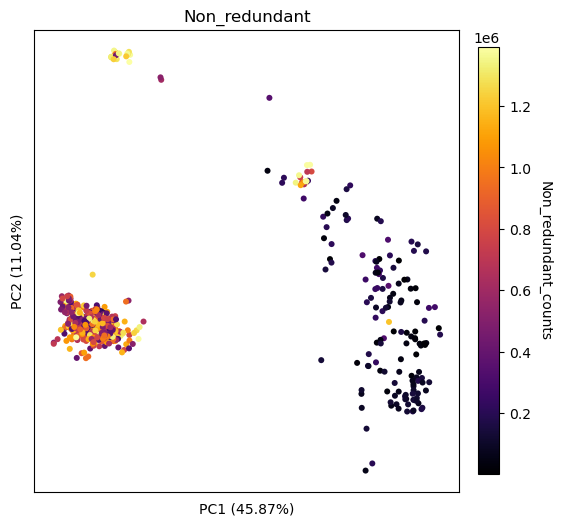

In [69]:
dimensionality_reduction(adata, method = 'pca')

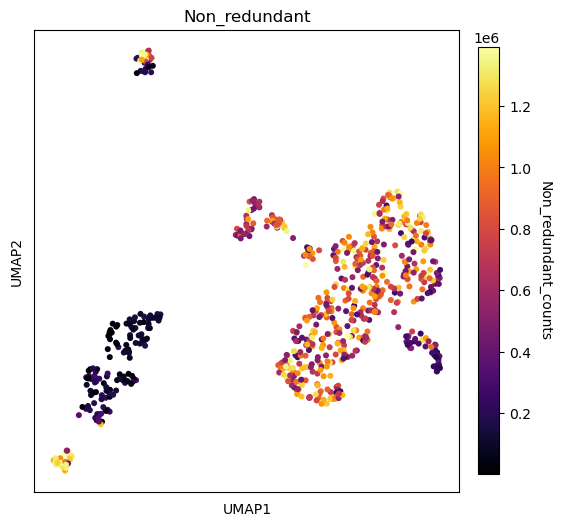

In [70]:
dimensionality_reduction(adata, method = 'umap')

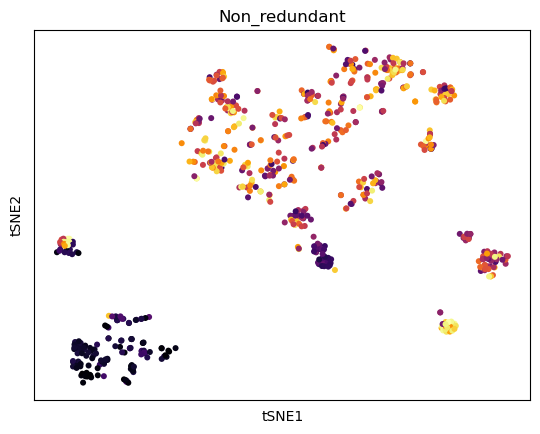

In [71]:
dimensionality_reduction(adata, method ='tsne')